# **Object Declumping**

***Prior to this notebook, you should have already run through [1.0_image_setup](1.0_image_setup.ipynb).***

The `'methods_...'` notebooks included here in infer-subc Part 1: segmentation workflows will go over how additional higher complexity functions are carried out. The notebooks will explain each step in the method and display the combined function at the end of the notebook. 

### **Biological Relevance**
Measurements of organelles and interaction sites use the masks that are provided by the segmentation workflows; however, sometimes the organelles that are segmented are grouped together due to high signals being too close together. By applying the declumping method here, we are able to separate the organelles that are in close proximity from each other, providing a better depiction of the organization of individual organelles of the same type within a cell. Additionally, by separating close proximity organelles in our segmentation, we gain an increased readout of organelle and interaction morphology metrics for the declumped organelles that are closer to the "true" makeup of the cell.

***We advise that you test the declumping process on a small, pilot dataset before committing to a particular declumping strategy and segmentation approach as it is possible to over-declump images.***


-----

### 👣 **Summary of steps**  

🛠️ **BUILD FUNCTION STEP-BY-STEP**

- **`STEP 1`** - Select desired organelle for declumping
    - Collect intensity image of the organelle that is desired
    - Collect segmentation image of the organelle that is desired

- **`STEP 2`** - Apply a highpass filter to the raw intensity image
    - Apply a lowpass gaussian filter to the raw intensity image
    - Subtract the lowpass from the raw intensity image to get the highpass image
    - (Optional) Apply a morphological opening to the highpass
    - (Optional) Repeat above steps n times using the highpass image as the raw intensity image

- **`STEP 3`** - Apply otsu thresholding & size filter to the image
    - Mathematically determine an optimal threshold for the image, and multiply it by an adjustment scalar
    - Apply the threshold to the image, setting everything above it to 1, and everything below it to 0
    - Remove objects that are below a specified size from the image

- **`STEP 4`** - Apply an inverted watershed
    - Invert the raw intensity image
    - Use the labeled thresholded image as "seeds" for the watershed
    - Apply the watershed masked with the segmentation image
    - Add the segmentation image back to the image to ensure smaller objects originally segmented are not lost

⚙️ **DEFINE AND TEST *`Declumping`* FUNCTIONS**

- Define `watershed_declumping` function
- Run `watershed_declumping` function

---------------------
## **IMPORTS AND LOAD IMAGE**
Details about the functions included in this subsection are outlined in the [`1.0_image_setup`](1.0_image_setup.ipynb) notebook. Please visit that notebook first if you are confused about any of the code included here.

In [1]:
from pathlib import Path
import os

import numpy as np
import pandas as pd

from skimage.morphology import opening
from skimage.filters import threshold_otsu
from skimage.segmentation import watershed
from scipy import ndimage
from aicssegmentation.core.utils import size_filter

from infer_subc.core.file_io import (list_image_files,
                                     read_czi_image)
from infer_subc.utils.batch import find_segmentation_tiff_files
from infer_subc.organelles.declumping import watershed_declumping
from infer_subc.core.img import label_uint16
from skimage.measure._label import label

import napari
from napari.utils.notebook_display import nbscreenshot
viewer = napari.Viewer()

#### &#x1F3C3; **Run code; no user input required**

#### &#x1F6D1; &#x270D; **User Input Required:**

Please specify the following information about your data: `raw_img_type`, `data_root_path`, `raw_data_path`, `seg_data_path`, and `quant_data_path`.

In [ ]:
#### USER INPUT REQUIRED ###
raw_img_type = ".tiff"
data_root_path = Path(os.path.expanduser("~")) / "Documents/Python Scripts/Infer-subc"
raw_data_path = data_root_path / "raw"
seg_data_path = data_root_path / "segmentations"

#### &#x1F3C3; **Run code; no user input required**

In [ ]:
# Create a list of the file paths for each image in the input folder. Select test image path.
raw_img_file_list = list_image_files(raw_data_path,raw_img_type)
pd.set_option('display.max_colwidth', None)
pd.DataFrame({"Image Name":raw_img_file_list})

#### &#x1F6D1; &#x270D; **User Input Required:**

Use the list above to specify which image you wish to analyze based on its index: `test_img_n`

In [4]:
#### USER INPUT REQUIRED ###
test_img_n = 0

#### &#x1F6D1; &#x270D; **User Input Required:**

Specify the organelle file name(s)'s suffix(es), and the channel that the organelle(s) appear(s) in the raw image

In [ ]:
org_file_names = ["lyso", "mito", "golgi", "perox", "ER", "LD"]
org_channels_ordered = [6, 0, 2, 4, 3, 1]

#### &#x1F3C3; **Run code; no user input required**

In [ ]:
# Read in the image and metadata as an ndarray and dictionary from the test image selected above. 
test_img_name = raw_img_file_list[test_img_n]
img_data,meta_dict = read_czi_image(test_img_name)

# Define some of the metadata features.
channel_names = meta_dict['name']
meta = meta_dict['metadata']['aicsimage']
scale = meta_dict['scale']
channel_axis = meta_dict['channel_axis']
file_path = meta_dict['file_name']

print("Metadata information")
print(f"File path: {file_path}")
for i in list(range(len(channel_names))):
    print(f"Channel {i} name: {channel_names[i]}")
print(f"Scale (ZYX): {scale}")
print(f"Channel axis: {channel_axis}")

filez = find_segmentation_tiff_files(file_path, org_file_names, seg_data_path, "-")

org_raws = {}
org_segs = {}
for chan, org in zip(org_channels_ordered, org_file_names):
    seg, md = read_czi_image(filez[org])

    viewer.add_image(img_data[chan], 
                     name=f"Raw {org}", 
                     scale=scale)
    org_raws[org]= img_data[chan]

    viewer.add_image(seg, 
                     name=f"Segmentation {org}", 
                     scale=scale)
    org_segs[org] = seg.astype(bool)  

print("The following matching files were found and can now be viewed in Napari:")
filez


---------------------
## **SEPARATE 'CLUMPED' ORGANELLES**

### **`STEP 1` - Select desired organelle to declump**

&#x1F453; **FYI:** To ensure we are only declumping a single organelle type, we will choose only a single organelle from our organelle list, and use the segmentation of that organelle as our segmentation image. This will exclude any other organelles from being involved in the declumping process.

#### &#x1F6D1; &#x270D; **User Input Required:**

Please specify which organelle you would like to examine, and which segmentation file should be used:
- `declump_org`: the suffix of the object you would like to declump; it should match one of the names included in the "org_file_names" variable above

In [7]:
#### USER INPUT REQUIRED ###
declump_org = "mito"

#### &#x1F3C3; **Run code; no user input required**

&#x1F453; **FYI:** The intensity and segmentation images will now be the only images in the Napari viewer. The intensity image will appear black and white, and the segmentation image will appear magenta. 

In [8]:
org_raw = org_raws[declump_org]
org_seg = org_segs[declump_org]

viewer.layers.clear()
viewer.add_image(org_raw, 
                 name=f"Raw {declump_org}", 
                 scale=scale)
viewer.add_image(org_seg, 
                 name=f"Segmentation {declump_org}",
                 scale=scale,
                 blending="translucent", 
                 opacity=0.7, 
                 colormap="magenta")

<Image layer 'Segmentation mito' at 0x1be40d3e020>

### **`STEP 2` - Apply highpass filter to raw intensity image**

&#x1F453; **FYI:** To find the specific peaks of intensity within the image, we use a highpass filter to remove all lower areas of intensity within an intensity gradient. This is done via creating a lowpass filter, then subtracting the lowpass filtered image from the raw image. This process is then repeated a number of times equal to the iteration value. Afterwards, an opening filter is optionally applied to the image.

#### &#x1F6D1; &#x270D; **User Input Required:**

Please specify the values to use for the filter. Higher values indicate more lowpass smoothing:
- `sigma`: the sigma to apply in the Gaussian filtering step; if 0 is used, no filter will be applied
- `open`: the True/False statement of whether to apply a morphological opening to the image
- `iterations`: the number of times to apply the above 3 values to generate the highpass image; minimum of 1

In [9]:
sigma = 1.34
open = False
iterations = 1

#### &#x1F3C3; **Run code; no user input required**

&#x1F453; **FYI:** This code block repeats the process of applying the specified median and Gaussian filters and choosing to apply the opening a number of times specified above. The image is then added to Napari as a new layer for visual comparison to the input image. 

Use the Napari viewer to view the image, and adjust the settings selected above accordingly.

In [10]:
highpass = org_raw.copy()
for _ in range(iterations):
    lowpass = ndimage.gaussian_filter(highpass, sigma)
    highpass -= lowpass
    np.clip(highpass, 0, None, out=highpass)
if open:
    highpass=opening(highpass)

viewer.add_image(highpass,
                 name=f"Highpass {declump_org}",
                 scale=scale,
                 blending="translucent", 
                 opacity=0.7, 
                 colormap="orange")

<Image layer 'Highpass mito' at 0x1be48c59750>

### **`STEP 3` - Apply highpass filter to raw intensity image**

&#x1F453; **FYI:** The peaks of intensity within the image are segmented from the highpass image using an otsu thresholding algorithm. Afterwards, small areas of the image are removed by a size filter.

#### &#x1F6D1; &#x270D; **User Input Required:**

Please specify the amount to adjust the threshold by:
- `thresh_adj`: a scalar value that is used to multiply the threshold by to find the desired threshold 
- `min_size`: the minimum connected voxels for a segmented object to remain segmented 

In [11]:
thresh_adj = 1.0
min_size = 0

#### &#x1F3C3; **Run code; no user input required**

&#x1F453; **FYI:** This code block applies the otsu threshold to the highpass image, then removes objects that are below a specified voxel count.

In [12]:
threshold = threshold_otsu(highpass)
ots = size_filter(img=(highpass >= (threshold*thresh_adj)), min_size=min_size, method='3D')

viewer.add_image(ots,
                 name=f"Otsu {declump_org}",
                 scale=scale,
                 blending="translucent", 
                 opacity=0.7, 
                 colormap="blue")

<Image layer 'Otsu mito' at 0x1be40616050>

### **`STEP 4` - Apply inverted watershed**

#### &#x1F3C3; **Run code; no user input required**

&#x1F453; **FYI:** This code block uses a watershed with the map as the inverse of the raw intensity image, the markers as the otsu filter, and the mask as the original organelle segmentation. This watershed is then added to the original organelle segmentation and relabeled to ensure no organelles were lost in the process of the watershed.

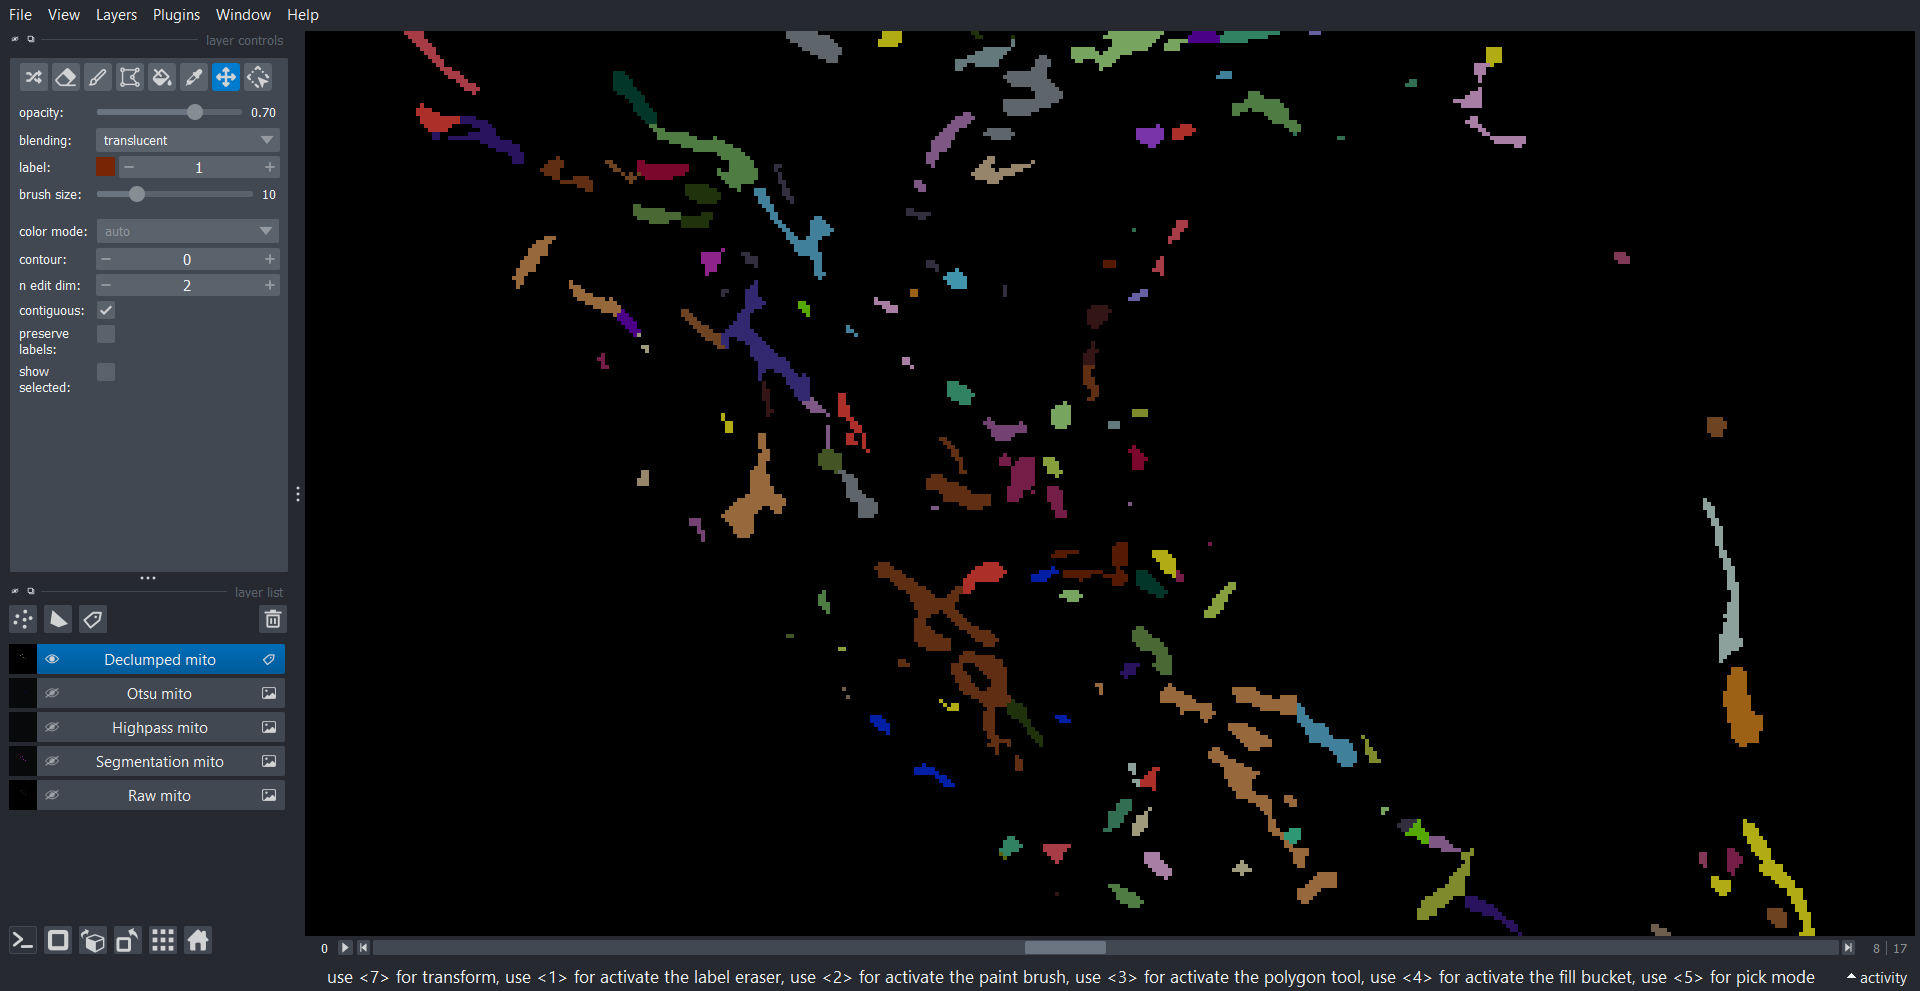

In [17]:
org_declump = label((org_seg) + watershed(image=(np.max(org_raw)-org_raw), 
                                                 markers=label_uint16(ots), 
                                                 mask=org_seg,
                                                 connectivity=np.ones((3, 3, 3), bool))).astype(np.uint16)

viewer.add_labels(org_declump,
                 name=f"Declumped {declump_org}",
                 scale=scale,
                 blending="translucent", 
                 opacity=0.7)

for i in range(-5,-1,1):
    viewer.layers[i].visible = False


# screenshot viewer
nbscreenshot(viewer, canvas_only = False)

### **`DEFINE` - The watershed_declumping function**

The following code includes an example of how the declumping steps above are combined into one function. This function will output a declumped segmentation. It is applied in the batch process functions available in [`1.2_infer_lysosome`](1.2_infer_lysosome.ipynb), [`1.3_infer_mitochondria`](1.2_infer_mitochondria.ipynb), [`1.4_infer_golgi`](1.2_infer_golgi.ipynb), [`1.5_infer_peroxisome`](1.5_infer_peroxisome.ipynb), [`1.6_infer_ER`](1.6_infer_ER.ipynb), and [`1.7_infer_lipid_droplet`](1.7_infer_lipid_droplet.ipynb) notebooks.

This function can utilized from infer-subc using:
```python
infer_subc.organelles.declumping.watershed_declumping()
```

#### &#x1F3C3; **Run code; no user input required**

&#x1F453; **FYI:** This code block defines the `watershed_declumping()` function. It is applied below.

In [14]:
def _watershed_declumping(raw_img:np.ndarray, seg_img:np.ndarray, declump:bool, 
                          sigma:float, iterations:int=1, open:bool=False, 
                          thresh_adj:float=1, min_size:int=0) -> np.ndarray:
    if declump and iterations>=1:
        highpass = raw_img.copy()
        for _ in range(iterations):
            lowpass = ndimage.gaussian_filter(highpass, sigma)
            highpass -= lowpass
            np.clip(highpass, 0, None, out=highpass)
        if open:
            highpass=opening(highpass)
        threshold = threshold_otsu(highpass)
        ots = size_filter(img=(highpass >= (threshold*thresh_adj)), min_size=min_size, method='3D')
        return label((seg_img) + watershed(image=(np.max(raw_img)-raw_img), 
                                                      markers=label_uint16(ots), 
                                                      mask=seg_img,
                                                      connectivity=np.ones((3, 3, 3), bool))).astype(np.uint16)
    else:
        return label_uint16(seg_img)

#### &#x1F3C3; **Run code; no user input required**

&#x1F453; **FYI:** This code block applies the function above to your test image. The settings specified above are applied here.

In [15]:
org_declump_test = _watershed_declumping(raw_img=org_raw,
                                         seg_img=org_seg,
                                         declump=True,
                                         sigma=sigma,
                                         iterations=iterations,
                                         open=open,
                                         thresh_adj=thresh_adj,
                                         min_size=min_size)

print("The declumping output here matches the output created above:")
print(f"{np.array_equal(org_declump, org_declump_test)}")

org_declump_fn = watershed_declumping(raw_img=org_raw,
                                         seg_img=org_seg,
                                         declump=True,
                                         sigma=sigma,
                                         iterations=iterations,
                                         open=open,
                                         thresh_adj=thresh_adj,
                                         min_size=min_size)

print("The declumping output here matches the output created with the integrated function:")
print(f"{np.array_equal(org_declump_fn, org_declump_test)}")

The declumping output here matches the output created above:
True
The declumping output here matches the output created with the integrated function:
True


##### &#x1F453; **FYI:** This function has been added to `infer_subc.organelles.declumping` and can be imported with the following:
> ```python
> from infer_subc.organelles.declumping import watershed_declumping
> ```

-----
### 🎉 **CONGRATULATIONS!! You've completed the `Declumping` method explanation notebook.**

This method is utilized in the following batch processing notebooks:

- [1.2_infer_lysosome](1.2_infer_lysosome.ipynb)
- [1.3_infer_mitochondria](1.2_infer_mitochondria.ipynb)
- [1.4_infer_golgi](1.2_infer_golgi.ipynb) 
- [1.5_infer_peroxisome](1.5_infer_peroxisome.ipynb)
- [1.6_infer_ER](1.6_infer_ER.ipynb)
- [1.7_infer_lipid_droplet](1.7_infer_lipid_droplet.ipynb)

Continue on to learn about the other methods included in `infer-subc`:
- [method_morphology](method_morphology.ipynb)
- [method_distribution](method_distribution.ipynb)
- [method_interactions](method_interactions.ipynb)
